# 1. Introduction

Gig workers are independent contractors. They are not in a fixed long-term relationship with the organization and they have the ability to set their own hours and move between different platforms easily. Hence, it is important to assess the daily and hourly activity of these drivers, to have an assurance of driver supply and availability in the near future. A year, month or day ahead forecast can help the utilities plan for a larger time scale but for smoother daily operations an hourly (or even better) forecast can prove very useful.

This project will involve analyzing activity of drivers with atleast ~ 2 years of history with the spark app to find trends in *Spark On* minutes spent around hour of the day, day of the week, season of the year etc. and also to check factors like hiked delivery fees and offer frequency that can impact the driver's willingness to go online. A model can be built to predict the time spent online with given parameters like day of week, time of day etc, season, holiday etc.

In [89]:
#importing all the required libraries and modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
from google.cloud import bigquery
plt.style.use('bmh')

# 2. Data

The table I extracted data from is a join between DRVR_APPLN_ACTV and DRVR. For the purpose of this project, I will be using data pertaining to only the Orlando region (has much data and diverse drivers) to study driver activity. To start off, we will be looking at a univariate analysis of minutes spent online during every hour for the past 2 years and then move on to a multivariate analysis on how other factors could be influencing the drivers. The most important attributes we require are DRVR_USER_ID, DRVR_ACTV_IND, ACTV_START_TS, ACTL_ACTV_END_TS, **ACTV_DUR_MIN_QTY**. The given data is a collection of irregular activity timestamps that are scattered randomly between minutes, hours and days. But for our project, we need a uniform timeline of every hour in the selected period of time and the value of number of minutes spent online during each of these slot hours.

In [23]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [24]:
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart Orlando' AND B.ACTV_NM = "ONLINE"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])
df["ACTV_START_TS"] = df["ACTV_START_TS"] + pd.Timedelta(hours=3) #converting pacific time to eastern time (orlando market)
df["ACTL_ACTV_END_TS"] = df["ACTL_ACTV_END_TS"] + pd.Timedelta(hours=3)
df.head()

,DRVR_USER_ID,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY,ACTV_DT
0,renemunoz28@hotmail.com,2021-06-13 15:50:23.694,2021-06-13 18:09:53.828,139.500000000,2021-06-13
1,edgarblasini@hotmail.com,2021-06-13 17:49:04.536,2021-06-13 19:28:05.444,99.000000000,2021-06-13
2,edgarblasini@hotmail.com,2021-06-13 17:49:04.536,2021-06-13 19:28:05.444,99.000000000,2021-06-13
3,eduardomillan702@gmail.com,2021-06-13 16:36:06.430,2021-06-13 19:03:47.040,147.670000000,2021-06-13
4,julioccastillosanchez@gmail.com,2021-06-13 16:07:37.528,2021-06-13 17:40:10.295,92.530000000,2021-06-13


In [25]:
df["DRVR_USER_ID"].value_counts().nlargest(n=10)

yesenia_leal_89@hotmail.com      5853
contreras_correia@hotmail.com    4589
borges.asdrubal@gmail.com        4292
luisrlo2001@gmail.com            4195
benoitsaidel@yahoo.fr            4045
naranjoangelg@gmail.com          3840
karepaujose1@gmail.com           3807
robingamez11usa@gmail.com        3779
girome8881@gmail.com             3315
eliothv@gmail.com                3286
Name: DRVR_USER_ID, dtype: int64

In [5]:
dfs = {}
for ID in df['DRVR_USER_ID'].value_counts()[0:50].index.tolist():
    dfs[ID] = df.loc[df['DRVR_USER_ID'] == ID]

In [26]:
def final(df):
    df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
    time_line = time_line.to_series()
    ts = pd.DataFrame(time_line,columns = ["dayhour"])
    ts = ts.set_index("dayhour")
    ts = pd.merge(ts,df,how="left",on=["dayhour"])
    ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
    ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
    ts = ts.set_index(["dayhour"],drop=True)
    ts = ts.drop_duplicates()
    ts = ts.dropna()
    ts = ts.reset_index(drop=False)
    ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    def create_final_data(df):
        df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
        df = df[df['minutes']>0].reset_index(drop=True)
        # create an IntervalIndex which we can set as the axis (needed for re-indexing).
        # subtract one minute from end_time so that the minute of the termination is excluded.
        iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                              df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                              closed='both')
        # create a new index with the extended frequency:
        new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
        # set the new index to get the extended frequency;
        # all minutes will have the value of the whole interval
        result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
        # we can now calculate the duration per hour by resampling and summing the
        # boolean representation of the duration (1/0):
        result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
        result.index.name = 'start_hour'
        return result
    re = create_final_data(ts)
    re = pd.DataFrame(re)
    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(re, label='minutes')

    ft = pd.concat([X, y], axis=1)
    
    hour_weekday = ft.pivot_table(values='minutes', index='hour', columns = 'dayofweek', aggfunc = 'mean')
    
    return hour_weekday
    #_ = plt.figure(figsize=(12, 8))
    #ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
    #_ = ax.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

In [118]:
final(dfs["maherabo42@gmail.com"])

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_21036\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_21036\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


dayofweek,0,1,2,3,4,5,6
hour,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,1.049180,0.655738,1.016129,0.295082,0.508197,0.000000
6,2.950820,6.147541,7.262295,8.209677,6.672131,8.934426,6.606557
7,33.049180,42.590164,45.193548,43.564516,48.934426,42.639344,42.016393
8,45.639344,52.754098,52.370968,51.290323,54.245902,54.950820,52.049180


In [6]:
def final_ft(df):
    df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
    time_line = time_line.to_series()
    ts = pd.DataFrame(time_line,columns = ["dayhour"])
    ts = ts.set_index("dayhour")
    ts = pd.merge(ts,df,how="left",on=["dayhour"])
    ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
    ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
    ts = ts.set_index(["dayhour"],drop=True)
    ts = ts.drop_duplicates()
    ts = ts.dropna()
    ts = ts.reset_index(drop=False)
    ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    def create_final_data(df):
        df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
        df = df[df['minutes']>0].reset_index(drop=True)
        # create an IntervalIndex which we can set as the axis (needed for re-indexing).
        # subtract one minute from end_time so that the minute of the termination is excluded.
        iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                              df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                              closed='both')
        # create a new index with the extended frequency:
        new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
        # set the new index to get the extended frequency;
        # all minutes will have the value of the whole interval
        result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
        # we can now calculate the duration per hour by resampling and summing the
        # boolean representation of the duration (1/0):
        result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
        result.index.name = 'start_hour'
        return result
    re = create_final_data(ts)
    re = pd.DataFrame(re)
    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.isocalendar().week

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(re, label='minutes')

    ft = pd.concat([X, y], axis=1)
    #hour_weekday = ft.pivot_table(values='minutes', index='hour', columns = 'dayofweek', aggfunc = 'mean')
    
    return ft

In [27]:
time_line = pd.date_range(df_yes["dayhour"].min(),df_yes["dayhour"].max(),freq='H')
time_line = time_line.to_series()
ts = pd.DataFrame(time_line,columns = ["dayhour"])
ts = ts.set_index("dayhour")
ts = pd.merge(ts,df_yes,how="left",on=["dayhour"])
ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)

NameError: name 'df_yes' is not defined

In [8]:
ts = ts.set_index(["dayhour"],drop=True)

In [9]:
len(ts)

12725

In [10]:
ts

,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY
dayhour,,,
2021-07-27 07:00:00,2021-07-27 07:47:50.711,2021-07-27 08:35:34.754,47.730000000
2021-07-27 07:00:00,2021-07-27 07:47:50.711,2021-07-27 08:35:34.754,47.730000000
2021-07-27 07:00:00,2021-07-27 07:47:50.711,2021-07-27 08:35:34.754,47.730000000
2021-07-27 08:00:00,NaT,NaT,0
2021-07-27 09:00:00,NaT,NaT,0
...,...,...,...
2022-07-07 10:00:00,2022-07-07 10:12:08.992,2022-07-07 10:22:14.418,10.100000000
2022-07-07 10:00:00,2022-07-07 10:12:08.992,2022-07-07 10:22:14.418,10.100000000
2022-07-07 11:00:00,2022-07-07 11:15:41.735,2022-07-07 14:30:00.000,194.320000000


In [11]:
ts = ts.drop_duplicates()
len(ts)

1949

In [12]:
ts = ts.dropna()
ts = ts.reset_index(drop=False)
ts

,dayhour,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY
0,2021-07-27 07:00:00,2021-07-27 07:47:50.711,2021-07-27 08:35:34.754,47.730000000
1,2021-07-27 10:00:00,2021-07-27 10:54:29.494,2021-07-27 11:42:02.522,47.550000000
2,2021-07-27 10:00:00,2021-07-27 10:16:51.300,2021-07-27 10:54:29.494,37.630000000
3,2021-07-27 11:00:00,2021-07-27 11:42:55.510,2021-07-27 12:06:13.222,23.300000000
4,2021-07-27 12:00:00,2021-07-27 12:29:37.246,2021-07-27 12:33:27.218,3.830000000
...,...,...,...,...
1943,2022-07-06 10:00:00,2022-07-06 10:16:28.933,2022-07-06 11:36:10.695,79.700000000
1944,2022-07-06 14:00:00,2022-07-06 14:09:37.524,2022-07-06 16:22:51.509,133.230000000
1945,2022-07-07 08:00:00,2022-07-07 08:13:44.732,2022-07-07 10:12:08.992,118.400000000
1946,2022-07-07 10:00:00,2022-07-07 10:12:08.992,2022-07-07 10:22:14.418,10.100000000


In [13]:
ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))

In [14]:
ts

,dayhour,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY
0,2021-07-27 07:00:00,2021-07-27 07:47:00,2021-07-27 08:35:00,47.730000000
1,2021-07-27 10:00:00,2021-07-27 10:54:00,2021-07-27 11:42:00,47.550000000
2,2021-07-27 10:00:00,2021-07-27 10:16:00,2021-07-27 10:54:00,37.630000000
3,2021-07-27 11:00:00,2021-07-27 11:42:00,2021-07-27 12:06:00,23.300000000
4,2021-07-27 12:00:00,2021-07-27 12:29:00,2021-07-27 12:33:00,3.830000000
...,...,...,...,...
1943,2022-07-06 10:00:00,2022-07-06 10:16:00,2022-07-06 11:36:00,79.700000000
1944,2022-07-06 14:00:00,2022-07-06 14:09:00,2022-07-06 16:22:00,133.230000000
1945,2022-07-07 08:00:00,2022-07-07 08:13:00,2022-07-07 10:12:00,118.400000000
1946,2022-07-07 10:00:00,2022-07-07 10:12:00,2022-07-07 10:22:00,10.100000000


In [15]:
def create_final_data(df):
    df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
    df = df[df['minutes']>0].reset_index(drop=True)
    # create an IntervalIndex which we can set as the axis (needed for re-indexing).
    # subtract one minute from end_time so that the minute of the termination is excluded.
    iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                          df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                          closed='both')
    # create a new index with the extended frequency:
    new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
    # set the new index to get the extended frequency;
    # all minutes will have the value of the whole interval
    result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
    # we can now calculate the duration per hour by resampling and summing the
    # boolean representation of the duration (1/0):
    result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
    result.index.name = 'start_hour'
    return result

In [16]:
re = create_final_data(ts)
re = pd.DataFrame(re)

In [17]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(re, label='minutes')

ft = pd.concat([X, y], axis=1)

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_21036\1090103005.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [18]:
ft.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes
start_hour,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,13
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,35
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0
2021-07-27 10:00:00,10,1,3,7,2021,208,27,30,44
2021-07-27 11:00:00,11,1,3,7,2021,208,27,30,60


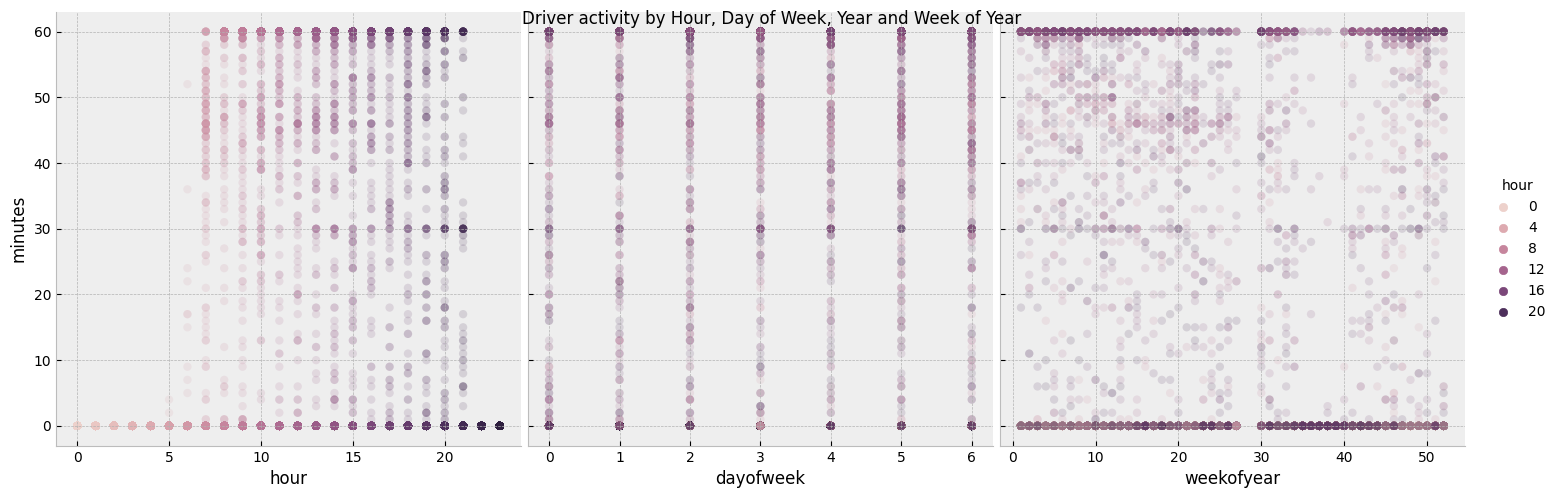

In [20]:
g = sns.pairplot(ft,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'weekofyear'],
             y_vars='minutes',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )

plt.suptitle('Driver activity by Hour, Day of Week, Year and Week of Year')
plt.show()

In [21]:
def slot_calc(hour):
    
    if hour in range(6,11):
        return "morning"
    elif hour in range(11,17):
        return "afternoon"
    elif hour in range(17,23):
        return "evening"

In [23]:
ft["slot"] = ft["hour"].apply(slot_calc)
ft

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes,slot
start_hour,,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,13,morning
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,35,morning
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0,morning
2021-07-27 10:00:00,10,1,3,7,2021,208,27,30,44,morning
2021-07-27 11:00:00,11,1,3,7,2021,208,27,30,60,afternoon
...,...,...,...,...,...,...,...,...,...,...
2022-07-07 10:00:00,10,3,3,7,2022,188,7,27,22,morning
2022-07-07 11:00:00,11,3,3,7,2022,188,7,27,45,afternoon
2022-07-07 12:00:00,12,3,3,7,2022,188,7,27,60,afternoon


# Data wrangling, exploration and stats

Plotting some graphs to get insights from the data.

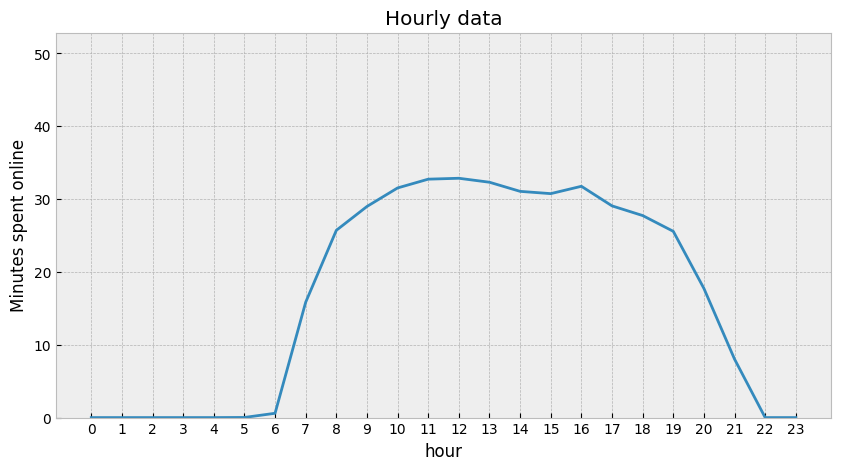

In [77]:
ft.groupby('hour')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('hour')['minutes'].mean() + 20 )])
_ = plt.xticks(ft['hour'].unique())
_ = plt.title('Hourly data')

- From the above average hourly online activity graph we can observe how the driver tends to turn on spark often during the day time and the activity gradually decreases towards night time.

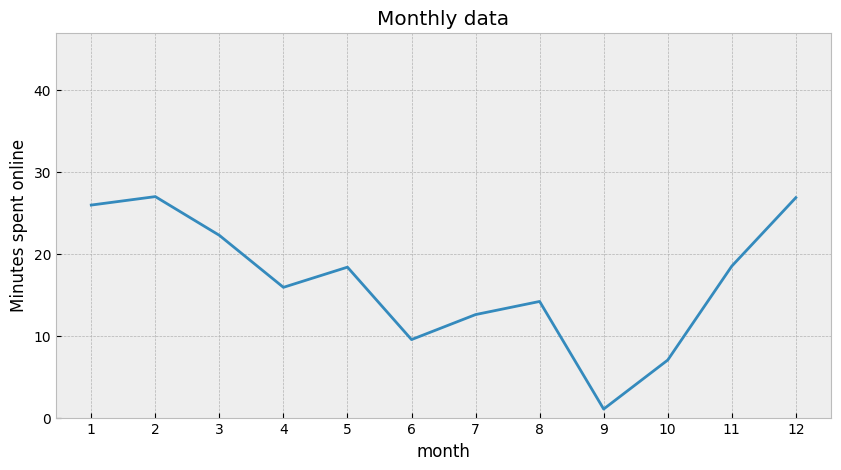

In [78]:
ft.groupby('month')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('month')['minutes'].mean() + 20 )])
_ = plt.xticks(ft['month'].unique())
_ = plt.title('Monthly data')

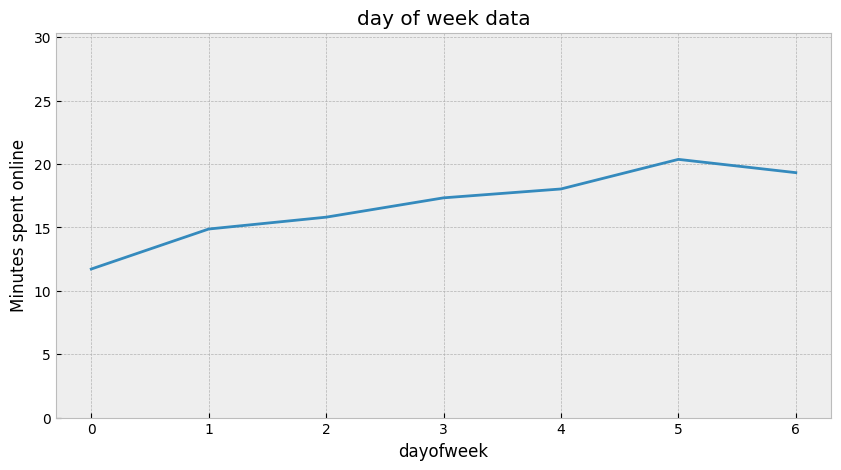

In [79]:
ft.groupby('dayofweek')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('dayofweek')['minutes'].mean() + 10 )])
_ = plt.xticks(ft['dayofweek'].unique())
_ = plt.title('day of week data')

In [85]:
[a,b] = [ft.groupby('dayofweek')['minutes'].mean().idxmax(),max(ft.groupby('dayofweek')['minutes'].mean())]

In [11]:
dfs_set = {}
for i in dfs.keys():
    dfs_set[i] = pd.DataFrame(final(dfs[i]))
    dfs_set[i]["ID"] = i

dfs_set["yesenia_leal_89@hotmail.com"]

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_9480\1797502193.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


dayofweek,0,1,2,3,4,5,6,ID
hour,,,,,,,,
0,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,yesenia_leal_89@hotmail.com
1,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,yesenia_leal_89@hotmail.com
2,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,yesenia_leal_89@hotmail.com
3,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,yesenia_leal_89@hotmail.com
4,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,yesenia_leal_89@hotmail.com
5,0.000000,0.00000,0.00,0.040000,0.081633,0.000000,0.000000,yesenia_leal_89@hotmail.com
6,0.183673,0.44898,0.64,1.180000,1.183673,0.489796,0.000000,yesenia_leal_89@hotmail.com
7,11.816327,14.96000,16.76,21.240000,22.306122,11.551020,12.142857,yesenia_leal_89@hotmail.com
8,17.979592,22.02000,25.98,32.100000,29.081633,23.632653,29.102041,yesenia_leal_89@hotmail.com


In [74]:
import itertools
from itertools import product

In [75]:
dff = pd.concat([dfs_set[i] for i in dfs_set.keys()], ignore_index=False)

In [76]:
dff

dayofweek,0,1,2,3,4,5,6,ID
hour,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,yesenia_leal_89@hotmail.com
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,yesenia_leal_89@hotmail.com
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,yesenia_leal_89@hotmail.com
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,yesenia_leal_89@hotmail.com
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,yesenia_leal_89@hotmail.com
...,...,...,...,...,...,...,...,...
19,3.387097,1.483871,0.935484,7.852459,2.245902,2.803279,0.0,karina.dugarte@gmail.com
20,0.338710,0.887097,0.000000,1.196721,0.180328,0.180328,0.0,karina.dugarte@gmail.com
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,karina.dugarte@gmail.com


In [77]:
dffn = dff.to_numpy()

In [78]:
dffn = dffn.reshape(50,24,8)

In [79]:
zv = np.argmax(dffn[:,:,:7],axis=0)

In [80]:
zv.shape

(24, 7)

In [81]:
zv

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 45],
       [37, 37, 37, 37, 37, 37, 45],
       [37, 37, 37, 37, 37, 37, 25],
       [37, 37, 37, 15, 37, 37,  2],
       [37, 10, 10,  4,  2,  2,  2],
       [37, 20, 10, 20,  2,  2,  2],
       [37, 20,  2, 20,  2,  2,  2],
       [37, 20,  2, 20, 20,  2,  2],
       [37,  2, 20, 20, 20,  2,  2],
       [37,  2,  4, 20,  2,  2,  2],
       [37,  2,  4, 20,  2,  2,  2],
       [ 2,  2,  4,  4,  2,  2,  2],
       [ 2,  2,  2,  2,  2,  2,  2],
       [ 2,  2,  2,  2,  2,  2,  2],
       [35,  1, 20, 20, 20, 20, 20],
       [35,  1, 18,  1, 20,  1, 47],
       [ 1,  1,  1,  1, 28,  1,  1],
       [18,  1, 18, 18, 28,  1,  1],
       [32, 32,  0, 42,  0,  0,  9],
       [ 0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [90]:
import plotly.graph_objects as go
        

fig = go.Figure(data=go.Heatmap(
                   z=zv,
                   x=[0,1,2,3,4,5,6],
                   y=list(range(24)),
                   hoverongaps = False))
fig.show()

In [28]:
hour_weekday = ft.pivot_table(values='minutes', index='hour', columns = 'dayofweek', aggfunc = 'mean')

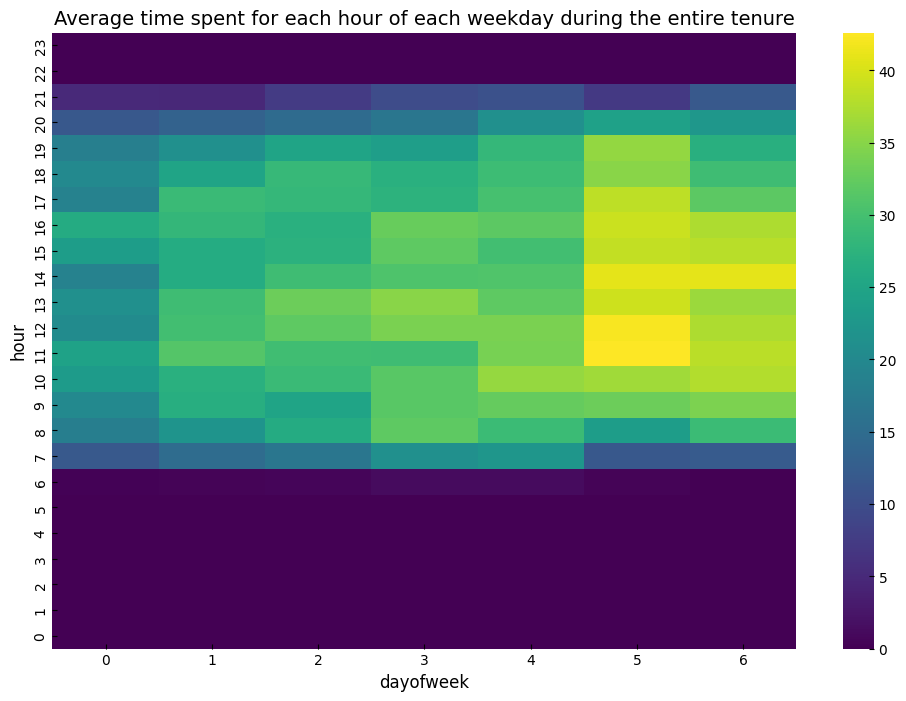

In [29]:
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

In [30]:
month_dict = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
day_dict = {0:"Monday",0:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
#fe = fe.replace({"dayofweek":day_dict})
#fe = fe.replace({"month":month_dict})

C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


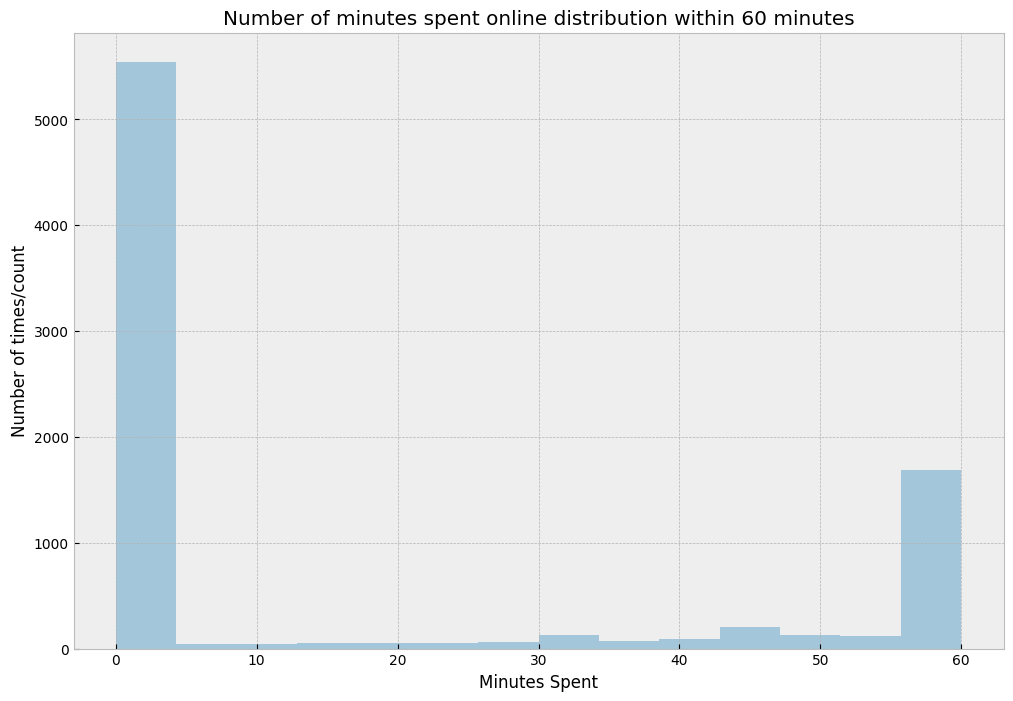

In [35]:
_ = plt.figure(figsize = (12,8))
_ = sns.distplot(ft['minutes'], kde=False)
_ = plt.title('Number of minutes spent online distribution within 60 minutes')
_ = plt.xlabel('Minutes Spent')
_ = plt.ylabel('Number of times/count')

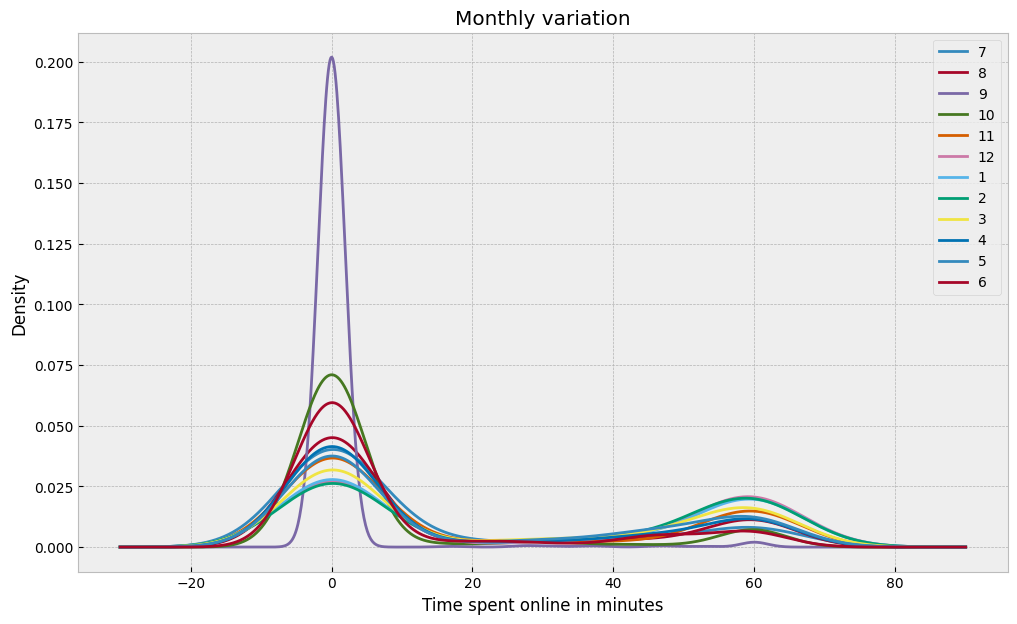

In [36]:
for month in ft['month'].unique():
    ft[ft['month'] == month]['minutes'].plot(kind='density', figsize = (12,7), legend = True, label = month)
_ = plt.xlabel('Time spent online in minutes')
_ = plt.title('Monthly variation')

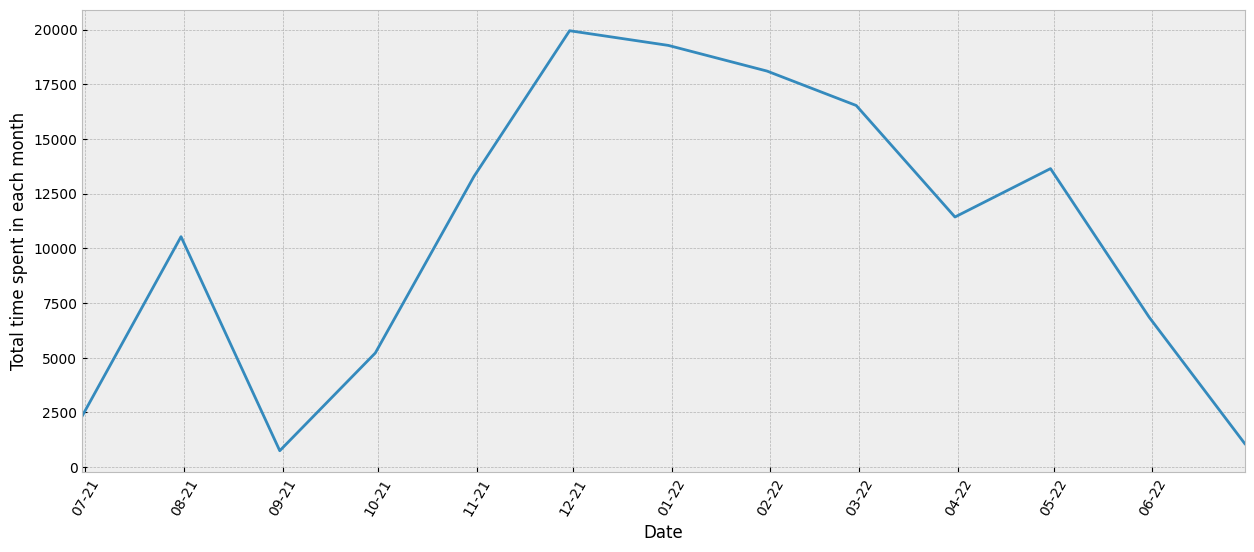

In [37]:
monthly_en = ft.resample('M', label = 'left')['minutes'].sum()
_ = plt.figure(figsize = (15,6))
_ = plt.plot(monthly_en)
_ = plt.xlim(monthly_en.index.min(), monthly_en.index.max())
locator = mdates.MonthLocator(bymonthday = 1, interval = 1)  # every month
fmt = mdates.DateFormatter('%m-%y')  # xticks to be displayed as 01-14 (i.e. Jan'14) and so on
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
_ = plt.xticks(rotation = 60)
_ = plt.ylabel('Total time spent in each month')
_ = plt.xlabel('Date')